In [ ]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
! git clone https://github.com/pierinim/tutorials.git

fatal: destination path 'tutorials' already exists and is not an empty directory.


In [ ]:
inputDir = "tutorials/Data/JetDataset"
! ls tutorials/Data/JetDataset/

jetImage_7_100p_0_10000.h5	jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5	jetImage_7_100p_80000_90000.h5


In [ ]:
target = np.array([])
jetList = np.array([])
datafiles = ['%s/jetImage_7_100p_30000_40000.h5' %inputDir,
           '%s/jetImage_7_100p_60000_70000.h5' %inputDir,
            '%s/jetImage_7_100p_50000_60000.h5' %inputDir,
            '%s/jetImage_7_100p_10000_20000.h5' %inputDir,
            '%s/jetImage_7_100p_0_10000.h5' %inputDir]
for i, fileIN in enumerate(datafiles):
    f=h5py.File(fileIN)
    if i == 0: print (f.get("particleFeatureNames")[:])
    print("Appending %s" %fileIN)
    myJetList = np.array(f.get("jetConstituentList"))
    mytarget = np.array (f.get("jets")[0:, -6:-1])
    jetList = np.concatenate([jetList, myJetList],axis = 0) if jetList.size else myJetList
    target = np.concatenate([target, mytarget], axis =0) if target.size else mytarget
    del myJetList, mytarget
    f.close()
print(target.shape, jetList.shape)    

[b'j1_px' b'j1_py' b'j1_pz' b'j1_e' b'j1_erel' b'j1_pt' b'j1_ptrel'
 b'j1_eta' b'j1_etarel' b'j1_etarot' b'j1_phi' b'j1_phirel' b'j1_phirot'
 b'j1_deltaR' b'j1_costheta' b'j1_costhetarel' b'j1_pdgid']
Appending tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5
Appending tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 100, 16)


In [ ]:
_#The dataset consists of 50000 with up to 100 particles in each jet. For each particle, 16 features are given (see printout)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(jetList, target, test_size=0.33)
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)
del jetList, target

(33500, 100, 16) (33500, 5) (16500, 100, 16) (16500, 5)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Conv1D, AveragePooling1D, Dropout, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [ ]:
featureArrayLength = (X_train.shape[1],X_train.shape[2])
dropoutRate = 0.25

In [ ]:
inputList = Input(shape=(featureArrayLength))
x = Conv1D(20, kernel_size=3, data_format="channels_last", strides=1, padding="valid", activation='relu')(inputList)
x = AveragePooling1D(pool_size=3)(x)
#
x = Conv1D(40, kernel_size=3, data_format="channels_last", strides=1, padding="valid", activation='relu')(x)
x = AveragePooling1D(pool_size=3)(x)
#
x = Conv1D(60, kernel_size=2, data_format="channels_last", strides=1, padding="valid", activation='relu')(x)
x = AveragePooling1D(pool_size=9)(x)
#
x = Flatten()(x)
x = Dense(20, activation='relu')(x)
x = Dropout(dropoutRate)(x)
x = Dense(10, activation='relu')(x)
x = Dropout(dropoutRate)(x)
output = Dense(5, activation='softmax')(x)
####
model = Model(inputs=inputList, outputs=output)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 16)]         0         
                                                                 
 conv1d (Conv1D)             (None, 98, 20)            980       
                                                                 
 average_pooling1d (AverageP  (None, 32, 20)           0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 40)            2440      
                                                                 
 average_pooling1d_1 (Averag  (None, 10, 40)           0         
 ePooling1D)                                                     
                                                                 
 conv1d_2 (Conv1D)           (None, 9, 60)             4860  

In [ ]:
batch_size = 128
n_epochs = 200

In [ ]:
# train 
history = model.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, Y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Epoch 1/200
262/262 - 5s - loss: 1.5098 - val_loss: 1.3897 - lr: 0.0010 - 5s/epoch - 21ms/step
Epoch 2/200
262/262 - 4s - loss: 1.3884 - val_loss: 1.3095 - lr: 0.0010 - 4s/epoch - 17ms/step
Epoch 3/200
262/262 - 4s - loss: 1.3307 - val_loss: 1.2691 - lr: 0.0010 - 4s/epoch - 15ms/step
Epoch 4/200
262/262 - 4s - loss: 1.3067 - val_loss: 1.2420 - lr: 0.0010 - 4s/epoch - 17ms/step
Epoch 5/200
262/262 - 5s - loss: 1.2808 - val_loss: 1.2205 - lr: 0.0010 - 5s/epoch - 19ms/step
Epoch 6/200
262/262 - 9s - loss: 1.2562 - val_loss: 1.1822 - lr: 0.0010 - 9s/epoch - 34ms/step
Epoch 7/200
262/262 - 9s - loss: 1.2313 - val_loss: 1.1509 - lr: 0.0010 - 9s/epoch - 36ms/step
Epoch 8/200
262/262 - 7s - loss: 1.1984 - val_loss: 1.0985 - lr: 0.0010 - 7s/epoch - 26ms/step
Epoch 9/200
262/262 - 6s - loss: 1.1626 - val_loss: 1.0624 - lr: 0.0010 - 6s/epoch - 22ms/step
Epoch 10/200
262/262 - 4s - loss: 1.1330 - val_loss: 1.0361 - lr: 0.0010 - 4s/epoch - 14ms/step
Epoch 11/200
262/262 - 4s - loss: 1.1213 - val_lo

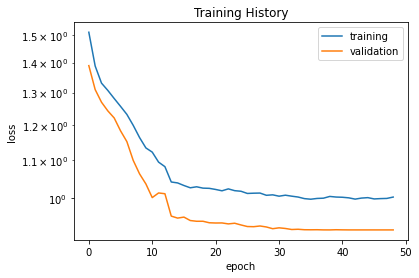

In [ ]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [ ]:
labels = ['gluon', 'quark', 'W', 'Z', 'top']

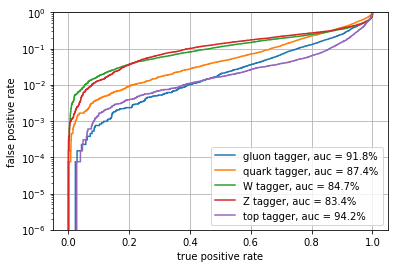

In [ ]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
predict_val = model.predict(X_val)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = Y_val[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("true positive rate")
plt.ylabel("false positive rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()